In [3]:
from pyspark.sql import SparkSession
import pyspark

from pyspark.sql import SparkSession
import pyspark
conf = pyspark.SparkConf().setAppName("Recommendation_Amazn").setMaster("spark://10.1.9.32:7077")
conf.set("spark.executor.memory", "6g")
conf.set('spark.driver.memoryOverhead','50g')
conf.set('spark.executor.cores',"4")
conf.set("spark.executor.instances", "8")
conf.set("spark.driver.memory", "49g")
conf.set("spark.sql.caseSensitive", "true")
conf.set("spark.debug.maxToStringFields", "100")
spark = SparkSession.builder.config(conf=conf).appName('Recommendation_Amazn').getOrCreate()

spark

In [4]:
print(spark.conf.get("spark.executor.memory"))
print(spark.conf.get("spark.driver.memoryOverhead"))
print(spark.conf.get("spark.executor.cores"))
print(spark.conf.get("spark.executor.instances"))
print(spark.conf.get("spark.driver.memory"))
print(spark.conf.get("spark.sql.caseSensitive"))
print(spark.conf.get("spark.debug.maxToStringFields"))

6g
50g
4
8
49g
true
100


In [2]:
spark.stop()

In [7]:
#spark.sparkContext.addFile("file:///home/it-center/Downloads/Arts_Crafts_and_Sewing.json")

In [5]:
df = spark.read.json("file:///home/it-center/Downloads/Arts_Crafts_and_Sewing.json")
df.show(10)

23/01/13 09:41:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-----+-------+--------------------+-----------+--------------+---------------+--------------------+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|   reviewerName|               style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+---------------+--------------------+--------------------+--------------+--------+----+
|0449819906| null|    5.0|I've read this bo...| 11 6, 2013|A3U4E9PIZ8OWH1| Shirley Curtis|{null, null, null...|   A  WONDERFUL BOOK|    1383696000|    true|   4|
|0449819906| null|    5.0|Nicely written di...|02 28, 2017|A3945D2TJ0PI86|       M. Smith|{null, null, null...|                Nice|    1488240000|    true|null|
|0449819906| null|    5.0|             love it|02 25, 2017|A2WZK72HLQ7SPT|Amazon Customer|{null, null, null...|          Five Stars|    1487980800|    true|null|
|0449819906| null|    5.0|Go

In [6]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color Name:: string (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Design:: string (nullable = true)
 |    |-- Display Height:: string (nullable = true)
 |    |-- Edition:: string (nullable = true)
 |    |-- Flavor:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Item Display Length:: string (nullable = true)
 |    |-- Item Display Weight:: string (nullable = true)
 |    |-- Item Package Quantity:: string (nullable = true)
 |    |-- Length:: string (nullable = true)
 |    |-- Material Type:: string (nullable = true)
 |    |-- Material:: string (nullable = t

In [7]:
df = df.withColumnRenamed("reviewerID","UserID").withColumnRenamed("asin","ItemID").withColumnRenamed("overall","rating")

In [24]:
df_new = df[['UserID', 'ItemID', 'rating']]
df_new.toPandas()

,UserID,ItemID,rating
0,A3U4E9PIZ8OWH1,0449819906,5.0
1,A3945D2TJ0PI86,0449819906,5.0
2,A2WZK72HLQ7SPT,0449819906,5.0
3,A1Q7YJ1NPE6E0W,0449819906,5.0
4,A2846L8Q507JC4,0449819906,5.0
...,...,...,...
2875912,A3DBSNSXS3HLW2,B01HJHR2PM,3.0
2875913,A335NB837Q8LWN,B01HJHR2PM,5.0
2875914,AKWXQAVB2U5ME,B01HJHR2PM,5.0
2875915,A2CWSI0186P0AY,B01HJHR2PM,1.0


In [25]:
best = df_new.filter(df_new.rating == 5.0)
best = best.sample(0.7).collect()[:120994]
very_good = df_new.filter(df_new.rating == 4.0)
very_good = very_good.sample(0.7).collect()[:120994]
decent = df_new.filter(df_new.rating == 3.0)
decent = decent.sample(0.7).collect()[:120994]
bad = df_new.filter(df_new.rating == 1.0)
bad = bad.sample(0.7).collect()[:120994]
df_new = df_new.where("rating==2.0")
#print(df_new.collect()[:99])

In [26]:
bestdf = spark.createDataFrame(best)
very_gooddf = spark.createDataFrame(very_good)
decentdf = spark.createDataFrame(decent)
baddf = spark.createDataFrame(bad)

In [28]:
merged = df_new.union(bestdf)
merged = merged.union(very_gooddf)
merged = merged.union(decentdf)
merged = merged.union(baddf)
merged.show()

+--------------+----------+------+
|        UserID|    ItemID|rating|
+--------------+----------+------+
|A3V21ZT37Y242L|0449819906|   2.0|
|A1GWGUBP1CUKGM|048625531X|   2.0|
|A3473JQJTGQ7TD|048625531X|   2.0|
|A3OWKFSSAWSOOP|0486417700|   2.0|
| AHZ1JD7R6B6HK|0486417700|   2.0|
| AC0J24YW9X2FO|0486473082|   2.0|
|A3NB7TBEBO5BW7|0848724666|   2.0|
|A20UNE9L6WKTSI|0865625247|   2.0|
|A2TJKPSX91YHE7|0865625247|   2.0|
|A25RE51VSYJNE1|0887248845|   2.0|
|A10ISK304ETSY1|0887248845|   2.0|
| AUYBZ4SOOAZNI|0970113706|   2.0|
|A2MDQC7VO80RY4|0970113706|   2.0|
|A3TRY91E7XXVCX|0988174979|   2.0|
|A3GDZ429DCH3SR|0988174979|   2.0|
|A3947KGRKNSIA4|0988174979|   2.0|
|  AKIQI350R5BZ|0988174979|   2.0|
| A1CKQ7TTVB1LZ|1450813917|   2.0|
| A2CRFOM39YNU5|1571208216|   2.0|
|A3LIQCAIWNHRGQ|1571208216|   2.0|
+--------------+----------+------+
only showing top 20 rows



In [29]:
df_col = merged.groupBy('rating').count().orderBy('count', ascending=False)
df_col.show(100)

+------+------+
|rating| count|
+------+------+
|   2.0|120994|
|   5.0|120994|
|   4.0|120994|
|   3.0|120994|
|   1.0|120994|
+------+------+



In [30]:
df_new = merged

In [31]:
df_new.describe().toPandas()

,summary,UserID,ItemID,rating
0,count,604970,604970,604970
1,mean,None,3.1045460801572733E9,3.0
2,stddev,None,3.218584359091071E9,1.4142147312040418
3,min,A0002686ZNGLCW7JVER2,0449819906,1.0
4,max,AZZZWDTD5URZ8,B01HJHR2PM,5.0


In [32]:
df_new.show()

+--------------+----------+------+
|        UserID|    ItemID|rating|
+--------------+----------+------+
|A3V21ZT37Y242L|0449819906|   2.0|
|A1GWGUBP1CUKGM|048625531X|   2.0|
|A3473JQJTGQ7TD|048625531X|   2.0|
|A3OWKFSSAWSOOP|0486417700|   2.0|
| AHZ1JD7R6B6HK|0486417700|   2.0|
| AC0J24YW9X2FO|0486473082|   2.0|
|A3NB7TBEBO5BW7|0848724666|   2.0|
|A20UNE9L6WKTSI|0865625247|   2.0|
|A2TJKPSX91YHE7|0865625247|   2.0|
|A25RE51VSYJNE1|0887248845|   2.0|
|A10ISK304ETSY1|0887248845|   2.0|
| AUYBZ4SOOAZNI|0970113706|   2.0|
|A2MDQC7VO80RY4|0970113706|   2.0|
|A3TRY91E7XXVCX|0988174979|   2.0|
|A3GDZ429DCH3SR|0988174979|   2.0|
|A3947KGRKNSIA4|0988174979|   2.0|
|  AKIQI350R5BZ|0988174979|   2.0|
| A1CKQ7TTVB1LZ|1450813917|   2.0|
| A2CRFOM39YNU5|1571208216|   2.0|
|A3LIQCAIWNHRGQ|1571208216|   2.0|
+--------------+----------+------+
only showing top 20 rows



In [33]:
from pyspark.sql.functions import isnan, when, count, col

df_new.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_new.columns]).show()

+------+------+------+
|UserID|ItemID|rating|
+------+------+------+
|     0|     0|     0|
+------+------+------+



In [34]:
df_new.filter(df_new.UserID.isNull()).show()

+------+------+------+
|UserID|ItemID|rating|
+------+------+------+
+------+------+------+



In [35]:
df_new.filter(df_new.ItemID.isNull()).show()

+------+------+------+
|UserID|ItemID|rating|
+------+------+------+
+------+------+------+



In [36]:
df_new.filter(df_new.rating.isNull()).show()

+------+------+------+
|UserID|ItemID|rating|
+------+------+------+
+------+------+------+



In [37]:
df_col = df_new.groupBy('rating').count().orderBy('count', ascending=False)
df_col.show(100)

+------+------+
|rating| count|
+------+------+
|   2.0|120994|
|   5.0|120994|
|   4.0|120994|
|   3.0|120994|
|   1.0|120994|
+------+------+



<AxesSubplot:ylabel='rating'>

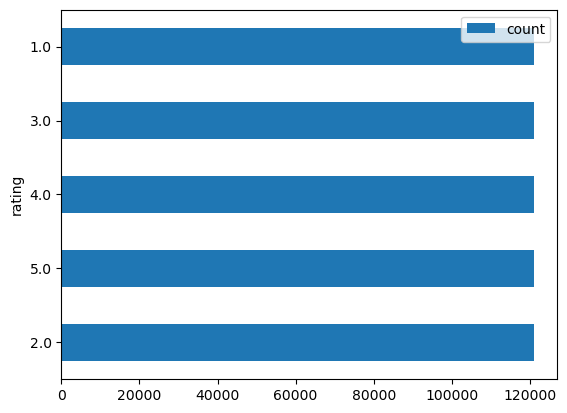

In [38]:
import matplotlib.pyplot as plt
import numpy as np

pdf1=df_col.toPandas()
pdf1.plot(kind='barh',x='rating',y='count')

In [39]:
df_col = df_new.groupBy('ItemID').count().orderBy('count', ascending=False)
df_col.show(10)

+----------+-----+
|    ItemID|count|
+----------+-----+
|B000F7DPEQ| 2414|
|B0014DGXU8| 2139|
|B000P0LNRE| 1867|
|B000Y00DDK| 1715|
|B000980L02| 1699|
|B000WOM50W| 1612|
|B000BQKGR0| 1545|
|B000B7Q9KM| 1454|
|B0001DUD9O| 1369|
|B000HF6YX0| 1287|
+----------+-----+
only showing top 10 rows



In [40]:
#pdf1=df_col.toPandas()
#pdf1.plot(kind='barh',x='ItemID',y='count')

In [47]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(df_new.columns)-set(['rating'])) ]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_new).transform(df_new)
transformed.show()

23/01/13 10:09:05 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


+--------------+----------+------+------------+------------+
|        UserID|    ItemID|rating|UserID_index|ItemID_index|
+--------------+----------+------+------------+------------+
|A3V21ZT37Y242L|0449819906|   2.0|    373432.0|      2192.0|
|A1GWGUBP1CUKGM|048625531X|   2.0|    131106.0|      2625.0|
|A3473JQJTGQ7TD|048625531X|   2.0|    297952.0|      2625.0|
|A3OWKFSSAWSOOP|0486417700|   2.0|    355928.0|     10815.0|
| AHZ1JD7R6B6HK|0486417700|   2.0|    416210.0|     10815.0|
| AC0J24YW9X2FO|0486473082|   2.0|     22833.0|      9174.0|
|A3NB7TBEBO5BW7|0848724666|   2.0|    351507.0|      1013.0|
|A20UNE9L6WKTSI|0865625247|   2.0|    187356.0|      7477.0|
|A2TJKPSX91YHE7|0865625247|   2.0|    267688.0|      7477.0|
|A25RE51VSYJNE1|0887248845|   2.0|    200921.0|      5680.0|
|A10ISK304ETSY1|0887248845|   2.0|     84872.0|      5680.0|
| AUYBZ4SOOAZNI|0970113706|   2.0|    452364.0|      6615.0|
|A2MDQC7VO80RY4|0970113706|   2.0|    247678.0|      6615.0|
|A3TRY91E7XXVCX|09881749

In [42]:
from pyspark.sql.functions import count as _count
from pyspark.sql.functions import countDistinct

df_new.select(countDistinct('UserID')).show()
df_new.select(countDistinct('ItemID')).show()

+----------------------+
|count(DISTINCT UserID)|
+----------------------+
|                466582|
+----------------------+



+----------------------+
|count(DISTINCT ItemID)|
+----------------------+
|                 80219|
+----------------------+



In [48]:
(training, test) = transformed.randomSplit([0.8, 0.2])
training.describe().toPandas()

23/01/11 16:03:52 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:04:29 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB


,summary,UserID,ItemID,rating,UserID_index,ItemID_index
0,count,2302454,2302454,2302454,2302454,2302454
1,mean,None,3.12894160760298E9,4.317392225859887,488029.21192649234,30897.498397796437
2,stddev,None,3.205872881517463E9,1.2187568832812568,482270.8468922584,56775.381464204154
3,min,A0002686ZNGLCW7JVER2,0001413724,1.0,0.0,0.0
4,max,AZZZWDTD5URZ8,B01HJHR2PM,5.0,1579229.0,302808.0


In [48]:
from pyspark.sql.functions import mean , stddev, col

mean_rating, sttdev_rating = transformed.select(mean("rating"), stddev("rating")).first()
transformed=transformed.withColumn("rating_Normalized", (col("rating") - mean_rating) / sttdev_rating)
transformed.show()

23/01/13 10:10:27 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


+--------------+----------+------+------------+------------+-------------------+
|        UserID|    ItemID|rating|UserID_index|ItemID_index|  rating_Normalized|
+--------------+----------+------+------------+------------+-------------------+
|A3V21ZT37Y242L|0449819906|   2.0|    373432.0|      2192.0|-0.7071061967715571|
|A1GWGUBP1CUKGM|048625531X|   2.0|    131106.0|      2625.0|-0.7071061967715571|
|A3473JQJTGQ7TD|048625531X|   2.0|    297952.0|      2625.0|-0.7071061967715571|
|A3OWKFSSAWSOOP|0486417700|   2.0|    355928.0|     10815.0|-0.7071061967715571|
| AHZ1JD7R6B6HK|0486417700|   2.0|    416210.0|     10815.0|-0.7071061967715571|
| AC0J24YW9X2FO|0486473082|   2.0|     22833.0|      9174.0|-0.7071061967715571|
|A3NB7TBEBO5BW7|0848724666|   2.0|    351507.0|      1013.0|-0.7071061967715571|
|A20UNE9L6WKTSI|0865625247|   2.0|    187356.0|      7477.0|-0.7071061967715571|
|A2TJKPSX91YHE7|0865625247|   2.0|    267688.0|      7477.0|-0.7071061967715571|
|A25RE51VSYJNE1|0887248845| 

In [53]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def tune_ALS(train_data, validation_data, maxIter, regParams, ranks):
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
            als = ALS(userCol="UserID_index", itemCol="ItemID_index", ratingCol="rating_Normalized", coldStartStrategy="drop").setMaxIter(maxIter).setRank(rank).setRegParam(reg)
            # train ALS model
            model = als.fit(train_data)
            print(als)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation_data)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating_Normalized",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model


In [51]:
train, test = transformed.randomSplit([0.8, 0.2], seed=1234)

In [54]:
als = tune_ALS(train, test, 15, [0.1, 0.2, 0.3, 0.0001, 0.001, 0.01], [1, 2, 3, 4, 5, 6])

23/01/13 10:22:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:22:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:23:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:23:51 ERROR TaskSchedulerImpl: Lost executor 7 on 10.1.9.7: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/01/13 10:23:51 WARN TaskSetManager: Lost task 8.0 in stage 178.0 (TID 4557) (10.1.9.7 executor 7): ExecutorLostFailure (executor 7 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/01/13 10:23:51 WARN TaskSetManager: Lost task 16.0 in stage 178.0 (TID 4565) (10.1.9.7 executor 7): ExecutorLostFailure (executor 7 exited caused by one of the running tasks) Reason: Remote RPC client disass

ALS_9b99c536568f


23/01/13 10:28:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:28:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:28:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:29:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 10:29:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.1: validation RMSE is 1.0818918284750456


23/01/13 10:29:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:29:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:29:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:30:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:30:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:30:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:30:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:30:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:30:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:30:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:30:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:31:05 WARN DAGScheduler: Broadc

ALS_e788ef4707d3


23/01/13 10:34:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:34:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:34:11 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:34:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 10:34:40 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.2: validation RMSE is 1.0060187882513798


23/01/13 10:34:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:34:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:35:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:35:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:35:25 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:35:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:35:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:35:55 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:36:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:36:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:36:15 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:36:22 WARN DAGScheduler: Broadc

ALS_bc6e5f95e03b


23/01/13 10:39:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:39:42 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:39:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:40:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 10:40:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.3: validation RMSE is 0.9775076897235256


23/01/13 10:40:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:40:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:40:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:40:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:40:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:41:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:41:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:41:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:41:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:41:40 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:41:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:41:55 WARN DAGScheduler: Broadc

ALS_4b21e6be2372


23/01/13 10:45:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:45:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:45:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:45:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 10:45:40 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.0001: validation RMSE is 3.773239553414654


23/01/13 10:45:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:45:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:46:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:46:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:46:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:46:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:46:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:46:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:47:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:47:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:47:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:47:24 WARN DAGScheduler: Broadc

ALS_0e051f3c900e


23/01/13 10:50:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:50:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:50:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:50:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 10:50:57 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.001: validation RMSE is 1.9069467805458198


23/01/13 10:51:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:51:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:51:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:51:35 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:51:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:51:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:52:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:52:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:52:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:52:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:52:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:52:37 WARN DAGScheduler: Broadc

ALS_a5280e3c8759


23/01/13 10:55:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:55:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:55:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:55:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 10:56:02 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.01: validation RMSE is 1.3377877470675812


23/01/13 10:56:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:56:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:56:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:56:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:56:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:57:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:57:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:57:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:57:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:57:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:57:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 10:57:45 WARN DAGScheduler: Broadc

ALS_151d14a90dc7


23/01/13 11:00:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:00:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:00:55 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:01:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:01:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.1: validation RMSE is 0.9890558194036593


23/01/13 11:01:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:01:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:01:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:02:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:02:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:02:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:02:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:02:40 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:02:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:02:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:02:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:03:06 WARN DAGScheduler: Broadc

ALS_41f491c87fe1


23/01/13 11:06:15 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:06:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:06:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:06:40 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:06:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.2: validation RMSE is 0.9418068013483206


23/01/13 11:06:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:06:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:07:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:07:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:07:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:07:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:07:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:07:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:08:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:08:11 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:08:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:08:25 WARN DAGScheduler: Broadc

ALS_7ca9378dff4b


23/01/13 11:11:35 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:11:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:11:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:12:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:12:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.3: validation RMSE is 0.9165750440142817


23/01/13 11:12:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:12:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:12:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:12:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:12:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:13:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:13:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:13:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:13:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:13:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:13:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:13:50 WARN DAGScheduler: Broadc

ALS_962e1aed167e


23/01/13 11:16:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:16:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:16:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:17:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:17:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.0001: validation RMSE is 4.8073622462767664


23/01/13 11:17:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:17:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:17:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:17:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:18:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:18:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:18:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:18:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:18:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:18:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:18:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:19:06 WARN DAGScheduler: Broadc

ALS_070107985e17


23/01/13 11:22:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:22:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:22:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:22:48 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:22:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.001: validation RMSE is 1.8140919126948074


23/01/13 11:23:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:23:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:23:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:23:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:23:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:23:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:24:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:24:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:24:15 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:24:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:24:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:24:38 WARN DAGScheduler: Broadc

ALS_64325d422552


23/01/13 11:27:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:27:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:27:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:28:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:28:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.01: validation RMSE is 1.1293821128343864


23/01/13 11:28:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:28:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:28:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:29:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:29:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:29:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:29:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:29:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:29:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:29:55 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:30:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:30:09 WARN DAGScheduler: Broadc

ALS_4abb5eba2431


23/01/13 11:33:15 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:33:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:33:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:33:40 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:33:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.1: validation RMSE is 0.9195167807022214


23/01/13 11:33:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:33:55 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:34:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:34:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:34:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:34:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:34:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:35:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:35:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:35:15 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:35:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:35:31 WARN DAGScheduler: Broadc

ALS_002a61bcabf6


23/01/13 11:38:47 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:38:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:38:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:39:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:39:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.2: validation RMSE is 0.889979756684198


23/01/13 11:39:25 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:39:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:39:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:39:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:40:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:40:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:40:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:40:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:40:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:40:47 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:40:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:41:00 WARN DAGScheduler: Broadc

ALS_325dc09c730e


23/01/13 11:44:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:44:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:44:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:44:32 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:44:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.3: validation RMSE is 0.8767195057292136


23/01/13 11:44:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:44:47 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:45:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:45:15 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:45:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:45:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:45:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:45:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:45:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:46:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:46:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:46:17 WARN DAGScheduler: Broadc

ALS_2107668abb1d


23/01/13 11:49:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:49:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:49:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:50:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:50:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.0001: validation RMSE is 3.5094281193500256


23/01/13 11:50:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:50:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:50:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:50:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:50:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:51:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:51:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:51:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:51:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:51:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:51:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:51:49 WARN DAGScheduler: Broadc

ALS_1aeebfff1939


23/01/13 11:54:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:54:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:54:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:55:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 11:55:26 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.001: validation RMSE is 1.7106483353032043


23/01/13 11:55:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:55:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:55:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:56:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:56:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:56:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:56:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:56:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:56:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:56:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:56:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:57:04 WARN DAGScheduler: Broadc

ALS_4966f62be23d


23/01/13 11:59:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:59:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 11:59:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:00:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:00:27 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.01: validation RMSE is 1.0479249703136468


23/01/13 12:00:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:00:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:00:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:01:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:01:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:01:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:01:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:01:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:01:47 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:01:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:02:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:02:08 WARN DAGScheduler: Broadc

ALS_02fc72f8192b


23/01/13 12:05:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:05:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:05:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:05:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:05:35 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.1: validation RMSE is 0.8701785049558813


23/01/13 12:05:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:05:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:05:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:06:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:06:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:06:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:06:40 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:06:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:06:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:07:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:07:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:07:17 WARN DAGScheduler: Broadc

ALS_4712e08d8fde


23/01/13 12:10:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:10:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:10:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:10:47 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:10:53 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.2: validation RMSE is 0.8554294757092886


23/01/13 12:10:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:11:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:11:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:11:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:11:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:11:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:11:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:12:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:12:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:12:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:12:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:12:33 WARN DAGScheduler: Broadc

ALS_6ed509ee709a


23/01/13 12:15:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:15:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:15:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:16:16 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:16:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.3: validation RMSE is 0.8519452355900528


23/01/13 12:16:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:16:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:16:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:17:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:17:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:17:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:17:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:17:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:17:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:17:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:17:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:18:07 WARN DAGScheduler: Broadc

ALS_fe910ae6f984


23/01/13 12:21:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:21:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:21:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:21:48 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:21:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.0001: validation RMSE is 2.975101782576371


23/01/13 12:21:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:22:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:22:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:22:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:22:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:22:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:23:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:23:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:23:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:23:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:23:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:23:33 WARN DAGScheduler: Broadc

ALS_5544f43e4366


23/01/13 12:26:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:26:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:26:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:27:03 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:27:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.001: validation RMSE is 1.583486685695729


23/01/13 12:27:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:27:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:27:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:27:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:27:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:28:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:28:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:28:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:28:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:28:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:28:40 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:28:46 WARN DAGScheduler: Broadc

ALS_ef45aad09f12


23/01/13 12:31:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:31:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:31:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:32:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:32:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.01: validation RMSE is 0.9966262004326052


23/01/13 12:32:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:32:40 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:32:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:33:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:33:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:33:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:33:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:33:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:33:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:33:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:34:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:34:09 WARN DAGScheduler: Broadc

ALS_da501291322e


23/01/13 12:37:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:37:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:37:14 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:37:38 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:37:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.1: validation RMSE is 0.8599616171948219


23/01/13 12:37:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:37:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:38:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:38:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:38:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:38:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:38:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:38:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:39:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:39:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:39:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:39:28 WARN DAGScheduler: Broadc

ALS_7b72f4f61e04


23/01/13 12:42:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:42:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:42:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:43:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:43:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.2: validation RMSE is 0.8466301591296962


23/01/13 12:43:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:43:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:43:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:43:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:43:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:44:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:44:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:44:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:44:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:44:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:44:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:44:57 WARN DAGScheduler: Broadc

ALS_4df21e46606d


23/01/13 12:48:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:48:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:48:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:48:35 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:48:42 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.3: validation RMSE is 0.8452735758407441


23/01/13 12:48:47 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:48:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:49:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:49:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:49:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:49:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:49:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:49:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:50:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:50:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:50:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:50:29 WARN DAGScheduler: Broadc

ALS_955db4d68d65


23/01/13 12:53:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:53:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:53:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:54:19 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:54:27 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.0001: validation RMSE is 3.061395323911952


23/01/13 12:54:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:54:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:54:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:55:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:55:14 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:55:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:55:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:55:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:55:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:55:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:56:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:56:13 WARN DAGScheduler: Broadc

ALS_f3287aa5cc40


23/01/13 12:59:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:59:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:59:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 12:59:45 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 12:59:52 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.001: validation RMSE is 1.5301764714148298


23/01/13 12:59:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:00:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:00:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:00:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:00:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:00:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:00:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:01:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:01:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:01:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:01:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:01:34 WARN DAGScheduler: Broadc

ALS_36bc5d3b893d


23/01/13 13:04:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:04:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:04:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:05:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 13:05:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.01: validation RMSE is 0.9555046338929601


23/01/13 13:05:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:05:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:05:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:05:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:06:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:06:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:06:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:06:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:06:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:06:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:06:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:07:04 WARN DAGScheduler: Broadc

ALS_86e55c53839b


23/01/13 13:10:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:10:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:10:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:10:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 13:10:50 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


6 latent factors and regularization = 0.1: validation RMSE is 0.8291245333409278


23/01/13 13:10:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:11:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:11:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:11:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:11:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:11:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:12:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:12:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:12:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:12:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:12:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:12:37 WARN DAGScheduler: Broadc

ALS_6a3de9c59c58


23/01/13 13:15:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:15:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:15:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:16:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 13:16:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


6 latent factors and regularization = 0.2: validation RMSE is 0.8238991129975067


23/01/13 13:16:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:16:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:16:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:17:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:17:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:17:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:17:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:17:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:17:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:17:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:17:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:18:06 WARN DAGScheduler: Broadc

ALS_44526b151fd1


23/01/13 13:21:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:21:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:21:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:21:48 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 13:21:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


6 latent factors and regularization = 0.3: validation RMSE is 0.8284702247373628


23/01/13 13:22:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:22:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:22:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:22:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:22:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:22:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:23:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:23:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:23:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:23:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:23:35 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:23:41 WARN DAGScheduler: Broadc

ALS_88d17b69fa07


23/01/13 13:26:55 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:26:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:26:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:27:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 13:27:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


6 latent factors and regularization = 0.0001: validation RMSE is 2.5938303782074286


23/01/13 13:27:35 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:27:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:27:55 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:28:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:28:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:28:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:28:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:28:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:28:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:29:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:29:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:29:13 WARN DAGScheduler: Broadc

ALS_1600a03740aa


23/01/13 13:32:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:32:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:32:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:33:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 13:33:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


6 latent factors and regularization = 0.001: validation RMSE is 1.3988443230886423


23/01/13 13:33:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:33:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:33:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:33:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:34:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:34:14 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:34:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:34:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:34:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:34:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:34:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:34:52 WARN DAGScheduler: Broadc

ALS_ad26837370cc


23/01/13 13:37:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:37:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:37:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 13:38:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 13:38:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


6 latent factors and regularization = 0.01: validation RMSE is 0.9315319377071185

The best model has 6 latent factors and regularization = 0.2


In [61]:
maxr = transformed.agg({"rating": "max"}).collect()[0][0]
minr = transformed.agg({"rating": "min"}).collect()[0][0]

transformed=transformed.withColumn("rating_minmax", (col("rating") - minr) /(maxr-minr))

In [62]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def tune_ALS(train_data, validation_data, maxIter, regParams, ranks):
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
            als = ALS(userCol="UserID_index", itemCol="ItemID_index", ratingCol="rating_minmax", coldStartStrategy="drop").setMaxIter(maxIter).setRank(rank).setRegParam(reg)
            # train ALS model
            model = als.fit(train_data)
            print(als)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation_data)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating_Normalized",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model


In [63]:
train, test = transformed.randomSplit([0.8, 0.2], seed=1234)

In [64]:
als = tune_ALS(train, test, 15, [0.1, 0.2, 0.3, 0.0001, 0.001, 0.01], [1, 2, 3, 4, 5, 6])

23/01/13 14:51:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:51:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:51:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:52:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:52:14 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:52:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:52:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:52:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:52:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:53:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:53:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:53:13 WARN DAGScheduler: Broadc

ALS_e8b2d13028c3


23/01/13 14:56:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:56:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:56:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:57:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 14:57:06 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.1: validation RMSE is 1.0052496385104037


23/01/13 14:57:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:57:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:57:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:57:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:57:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:58:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:58:14 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:58:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:58:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:58:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:58:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 14:58:49 WARN DAGScheduler: Broadc

ALS_5c4c4c5e8e57


23/01/13 15:01:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:01:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:01:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:02:24 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:02:28 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.2: validation RMSE is 0.9766188742254182


23/01/13 15:02:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:02:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:02:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:03:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:03:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:03:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:03:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:03:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:03:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:03:55 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:04:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:04:09 WARN DAGScheduler: Broadc

ALS_b9a7df6b8026


23/01/13 15:07:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:07:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:07:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:07:44 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:07:50 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.3: validation RMSE is 0.9575178425036843


23/01/13 15:07:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:08:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:08:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:08:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:08:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:08:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:09:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:09:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:09:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:09:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:09:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:09:35 WARN DAGScheduler: Broadc

ALS_d3e573f10590


23/01/13 15:12:42 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:12:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:12:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:13:09 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:13:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.0001: validation RMSE is 2.1586523033299487


23/01/13 15:13:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:13:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:13:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:13:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:13:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:14:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:14:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:14:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:14:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:14:40 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:14:47 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:14:54 WARN DAGScheduler: Broadc

ALS_20df61f4183f


23/01/13 15:17:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:17:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:17:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:18:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:18:28 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.001: validation RMSE is 1.3565749494546375


23/01/13 15:18:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:18:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:18:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:19:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:19:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:19:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:19:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:19:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:19:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:19:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:20:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:20:10 WARN DAGScheduler: Broadc

ALS_2767399c0e37


23/01/13 15:23:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:23:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:23:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:23:43 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:23:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


1 latent factors and regularization = 0.01: validation RMSE is 1.1155110993947854


23/01/13 15:23:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:23:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:24:15 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:24:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:24:35 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:24:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:24:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:25:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:25:11 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:25:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:25:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:25:32 WARN DAGScheduler: Broadc

ALS_dbfb22656cf4


23/01/13 15:28:35 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:28:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:28:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:29:03 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:29:08 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.1: validation RMSE is 0.9709060214307845


23/01/13 15:29:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:29:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:29:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:29:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:29:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:30:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:30:14 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:30:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:30:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:30:35 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:30:42 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:30:49 WARN DAGScheduler: Broadc

ALS_e08f04825291


23/01/13 15:33:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:33:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:33:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:34:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:34:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.2: validation RMSE is 0.9465077184538544


23/01/13 15:34:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:34:35 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:34:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:35:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:35:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:35:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:35:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:35:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:35:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:35:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:36:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:36:09 WARN DAGScheduler: Broadc

ALS_726259bcc72b


23/01/13 15:39:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:39:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:39:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:39:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:40:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.3: validation RMSE is 0.9366787502307332


23/01/13 15:40:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:40:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:40:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:40:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:40:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:40:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:41:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:41:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:41:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:41:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:41:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:41:39 WARN DAGScheduler: Broadc

ALS_2f4b256ce80b


23/01/13 15:44:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:44:42 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:44:42 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:45:09 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:45:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.0001: validation RMSE is 1.9464808502352124


23/01/13 15:45:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:45:25 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:45:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:45:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:46:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:46:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:46:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:46:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:46:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:46:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:46:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:46:59 WARN DAGScheduler: Broadc

ALS_dce61d74bd48


23/01/13 15:50:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:50:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:50:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:50:31 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:50:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.001: validation RMSE is 1.2074775162455353


23/01/13 15:50:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:50:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:51:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:51:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:51:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:51:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:51:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:51:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:51:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:52:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:52:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:52:18 WARN DAGScheduler: Broadc

ALS_b27a5c7f934e


23/01/13 15:55:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:55:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:55:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:56:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 15:56:07 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


2 latent factors and regularization = 0.01: validation RMSE is 1.0335508974873593


23/01/13 15:56:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:56:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:56:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:56:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:56:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:57:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:57:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:57:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:57:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:57:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:57:40 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 15:57:47 WARN DAGScheduler: Broadc

ALS_ed7262e0f7fc


23/01/13 16:00:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:00:47 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:00:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:01:13 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:01:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.1: validation RMSE is 0.9269942847247723


23/01/13 16:01:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:01:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:01:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:01:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:02:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:02:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:02:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:02:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:02:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:02:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:02:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:02:56 WARN DAGScheduler: Broadc

ALS_6b3ff6ecf3c3


23/01/13 16:06:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:06:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:06:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:06:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:06:34 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.2: validation RMSE is 0.9132851891765784


23/01/13 16:06:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:06:42 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:06:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:07:11 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:07:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:07:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:07:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:07:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:07:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:08:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:08:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:08:16 WARN DAGScheduler: Broadc

ALS_de7f24bd2799


23/01/13 16:11:25 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:11:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:11:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:11:54 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:12:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.3: validation RMSE is 0.9158454832506342


23/01/13 16:12:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:12:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:12:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:12:37 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:12:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:12:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:13:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:13:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:13:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:13:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:13:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:13:39 WARN DAGScheduler: Broadc

ALS_1e06f6e41f26


23/01/13 16:16:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:16:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:16:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:17:15 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:17:21 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.0001: validation RMSE is 2.0014409319210893


23/01/13 16:17:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:17:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:17:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:18:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:18:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:18:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:18:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:18:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:18:40 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:18:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:18:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:19:00 WARN DAGScheduler: Broadc

ALS_b899aafdcdc3


23/01/13 16:22:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:22:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:22:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:22:39 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:22:45 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.001: validation RMSE is 1.1796110545952165


23/01/13 16:22:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:22:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:23:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:23:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:23:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:23:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:23:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:23:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:24:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:24:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:24:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:24:24 WARN DAGScheduler: Broadc

ALS_abd38f83b583


23/01/13 16:27:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:27:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:27:33 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:27:58 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:28:03 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


3 latent factors and regularization = 0.01: validation RMSE is 0.9923977279712117


23/01/13 16:28:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:28:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:28:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:28:42 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:28:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:29:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:29:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:29:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:29:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:29:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:29:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:29:46 WARN DAGScheduler: Broadc

ALS_34495803ca37


23/01/13 16:32:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:32:51 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:32:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:33:14 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:33:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.1: validation RMSE is 0.8907351858738161


23/01/13 16:33:25 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:33:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:33:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:33:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:34:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:34:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:34:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:34:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:34:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:34:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:34:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:35:04 WARN DAGScheduler: Broadc

ALS_62afac078818


23/01/13 16:38:11 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:38:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:38:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:38:37 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:38:45 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.2: validation RMSE is 0.8908822941339966


23/01/13 16:38:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:38:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:39:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:39:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:39:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:39:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:39:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:40:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:40:09 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:40:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:40:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:40:30 WARN DAGScheduler: Broadc

ALS_9d9f3052bf34


23/01/13 16:43:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:43:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:43:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:44:16 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:44:23 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.3: validation RMSE is 0.9009283813444433


23/01/13 16:44:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:44:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:44:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:45:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:45:11 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:45:25 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:45:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:45:40 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:45:47 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:45:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:46:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:46:09 WARN DAGScheduler: Broadc

ALS_e7717b83d879


23/01/13 16:49:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:49:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:49:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:49:51 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:49:57 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.0001: validation RMSE is 1.9057096391639397


23/01/13 16:50:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:50:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:50:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:50:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:50:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:50:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:51:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:51:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:51:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:51:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:51:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:51:43 WARN DAGScheduler: Broadc

ALS_7758a3c82420


23/01/13 16:54:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:54:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:54:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:55:25 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 16:55:30 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.001: validation RMSE is 1.1614384633194406


23/01/13 16:55:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:55:40 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:55:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:56:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:56:15 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:56:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:56:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:56:42 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:56:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:56:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:57:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 16:57:09 WARN DAGScheduler: Broadc

ALS_04039f9312ac


23/01/13 17:00:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:00:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:00:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:00:37 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 17:00:42 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


4 latent factors and regularization = 0.01: validation RMSE is 0.9648158928658777


23/01/13 17:00:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:00:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:01:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:01:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:01:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:01:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:01:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:01:59 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:02:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:02:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:02:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:02:26 WARN DAGScheduler: Broadc

ALS_3dfcc658beed


23/01/13 17:05:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:05:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:05:25 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:05:50 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 17:05:56 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.1: validation RMSE is 0.8865940727561562


23/01/13 17:06:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:06:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:06:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:06:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:06:42 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:06:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:07:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:07:12 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:07:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:07:27 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:07:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:07:41 WARN DAGScheduler: Broadc

ALS_80213bd4a652


23/01/13 17:10:55 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:10:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:10:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:11:22 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 17:11:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.2: validation RMSE is 0.891296614687658


23/01/13 17:11:35 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:11:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:11:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:12:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:12:14 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:12:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:12:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:12:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:12:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:12:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:13:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:13:11 WARN DAGScheduler: Broadc

ALS_5c7dbebf79ce


23/01/13 17:16:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:16:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:16:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:16:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 17:16:55 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.3: validation RMSE is 0.902643741115473


23/01/13 17:17:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:17:06 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:17:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:17:34 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:17:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:17:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:18:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:18:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:18:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:18:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:18:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:18:37 WARN DAGScheduler: Broadc

ALS_fb31e2c087da


23/01/13 17:21:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:21:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:21:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:22:10 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 17:22:17 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.0001: validation RMSE is 1.7397465288915275


23/01/13 17:22:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:22:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:22:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:22:57 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:23:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:23:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:23:25 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:23:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:23:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:23:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:23:52 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:23:58 WARN DAGScheduler: Broadc

ALS_3d910865d6c2


23/01/13 17:27:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:27:03 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:27:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:27:29 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 17:27:36 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.001: validation RMSE is 1.1290462784485864


23/01/13 17:27:42 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:27:45 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:28:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:28:14 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:28:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:28:36 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:28:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:28:50 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:28:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:29:04 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:29:10 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:29:18 WARN DAGScheduler: Broadc

ALS_a4da356d5794


23/01/13 17:32:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:32:18 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:32:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:32:42 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 17:32:49 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


5 latent factors and regularization = 0.01: validation RMSE is 0.9379214231426662


23/01/13 17:32:56 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:33:00 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:33:15 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:33:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:33:35 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:33:49 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:33:55 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:34:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:34:07 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:34:13 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:34:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:34:26 WARN DAGScheduler: Broadc

ALS_dea878860fb1


23/01/13 17:37:22 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:37:23 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:37:24 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:37:46 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 17:37:53 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


6 latent factors and regularization = 0.1: validation RMSE is 0.8671074127332243


23/01/13 17:37:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:38:02 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:38:17 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:38:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:38:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:38:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:39:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:39:08 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:39:14 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:39:21 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:39:28 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:39:34 WARN DAGScheduler: Broadc

ALS_4a9f26252bb7


23/01/13 17:42:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:42:47 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:42:47 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:43:12 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
23/01/13 17:43:18 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


6 latent factors and regularization = 0.2: validation RMSE is 0.8736959036143861


23/01/13 17:43:25 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:43:29 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:43:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:43:58 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:44:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:44:19 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:44:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:44:32 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:44:39 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:44:46 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:44:54 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
23/01/13 17:45:00 WARN DAGScheduler: Broadc

KeyboardInterrupt: 

In [49]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

als = ALS(rank=5,regParam=0.1, maxIter=10, seed=0, nonnegative=True, coldStartStrategy="drop", userCol="UserID_index", itemCol="ItemID_index", ratingCol="rating")
model = als.fit(training)

23/01/11 16:04:47 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:05:03 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:05:27 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:05:47 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:06:09 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:06:29 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:06:45 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:07:04 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:07:21 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:07:41 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:07:58 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:08:17 WARN DAGScheduler: Broadc

In [50]:
predictions = model.transform(test)
predictions.show(10)

23/01/11 16:13:41 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:13:44 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:13:48 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:14:36 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:15:05 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB


+--------------+----------+------+------------+------------+----------+
|        UserID|    ItemID|rating|UserID_index|ItemID_index|prediction|
+--------------+----------+------+------------+------------+----------+
|A3AVTACQBDD44R|B01GLS0C2K|   5.0|     18147.0|        31.0|  4.053946|
|A3NVWWDF437JBD|B01GLS0C2K|   4.0|     33655.0|        31.0| 3.1472015|
|A2JEL4JXAL400A|B01GLS0C2K|   5.0|     40197.0|        31.0| 1.7169056|
|A22VZ0T4GJF18N|B01GLS0C2K|   5.0|    158053.0|        31.0|  3.951733|
|A30JL3BVWU8A17|B01GLS0C2K|   5.0|    180607.0|        31.0|  3.058573|
|A1OICANG5FJ7YF|B01GLS0C2K|   4.0|    269429.0|        31.0|  2.305562|
|A12H1GXF19QW3Y|B01GLS0C2K|   5.0|     11880.0|        31.0|  2.018669|
|A24UCOW3QMU4E8|B01GLS0C2K|   5.0|     17166.0|        31.0| 4.8294754|
|A195T7TVNKIFY7|B01GLS0C2K|   5.0|     90031.0|        31.0|  3.074284|
|A2WJ55I2S7BX9I|B01GLS0C2K|   5.0|    109430.0|        31.0| 3.4995706|
+--------------+----------+------+------------+------------+----

In [51]:
single_user = test.filter(test['UserID_index']==15245.0).select(['ItemID_index','UserID_index'])
# User had 10 ratings in the test data set 
# Realistically this should be some sort of hold out set!
single_user.show()

23/01/11 16:15:17 WARN DAGScheduler: Broadcasting large task binary with size 77.2 MiB
23/01/11 16:15:27 WARN DAGScheduler: Broadcasting large task binary with size 77.2 MiB
23/01/11 16:15:43 WARN DAGScheduler: Broadcasting large task binary with size 77.2 MiB


+------------+------------+
|ItemID_index|UserID_index|
+------------+------------+
|      1585.0|     15245.0|
|       258.0|     15245.0|
|     10618.0|     15245.0|
+------------+------------+



In [52]:
from pyspark.ml.evaluation import RegressionEvaluator

In [53]:
rmse = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(predictions)
mae = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="mae")
mae = mae.evaluate(predictions)
r2 = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(predictions)

print("RMSE: ", rmse)

23/01/11 16:16:06 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:16:09 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:16:12 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:16:56 WARN DAGScheduler: Broadcasting large task binary with size 77.3 MiB
23/01/11 16:18:16 ERROR TaskSchedulerImpl: Lost executor 2 on 10.1.9.57: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/01/11 16:18:16 WARN TaskSetManager: Lost task 2.0 in stage 221.0 (TID 675) (10.1.9.57 executor 2): ExecutorLostFailure (executor 2 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/01/11 16:18:16 WARN TaskSetManager: Lost task 10.0 in stage 221.0 (TID 683) (10.1.9.57 executor 2): ExecutorLostFailure

RMSE:  1.4475883492718296


In [54]:
print("MAE: ", mae)
print("R2: ", r2)

MAE:  1.0344300603920686
R2:  -0.8019078526847927


In [ ]:
#25min 